# 分割 batchnorm

In [1]:
from testing import viz_expr # 可视化 relay

In [2]:
import tvm
from tvm import relay
from tvm.relay.dataflow_pattern import *

In [3]:
def get_BN(x, var, mean, beta, gamma, eps):
    return gamma * (x - mean) / relay.op.sqrt(var + eps) + beta

构建计算图：

In [4]:
x = relay.var("x")
var = relay.var("var")
mean = relay.var("mean")
beta = relay.var("beta")
gamma = relay.var("gamma")
eps = relay.const(1e-5)
BN = get_BN(x, var, mean, beta, gamma, eps)

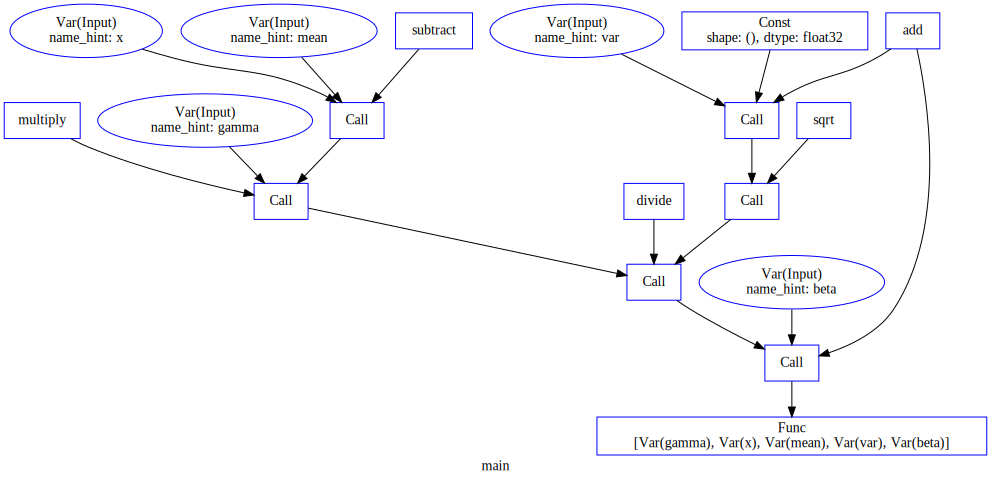

In [5]:
viz_expr(BN)

In [6]:
print(tvm.IRModule.from_expr(BN))

def @main(%gamma, %x, %mean, %var, %beta) {
  %0 = subtract(%x, %mean);
  %1 = add(%var, 1e-05f);
  %2 = multiply(%gamma, %0);
  %3 = sqrt(%1);
  %4 = divide(%2, %3);
  add(%4, %beta)
}



分割计算图：

In [9]:
class BatchnormCallback(DFPatternCallback):
    def __init__(self):
        super(BatchnormCallback, self).__init__()
        self.x = wildcard()
        self.var = wildcard()
        self.mean = wildcard()
        self.beta = wildcard()
        self.gamma = wildcard()
        self.eps = is_constant()

        self.pattern = (
            self.gamma * (self.x - self.mean) / is_op("sqrt")(self.var + self.eps) + self.beta
        )

    def callback(self, pre, post, node_map):
        x = node_map[self.x][0]
        var = node_map[self.var][0]
        mean = node_map[self.mean][0]
        beta = node_map[self.beta][0]
        gamma = node_map[self.gamma][0]
        eps = node_map[self.eps][0]
        return relay.op.nn.batch_norm(x, gamma, beta, mean, var, epsilon=eps.data.numpy().item())[0]

In [10]:
partitioned = BatchnormCallback().pattern.partition(BN)

In [11]:
print(tvm.IRModule.from_expr(partitioned))

def @main(%gamma, %x, %mean, %var, %beta) {
  %5 = fn (%FunctionVar_0_0, %FunctionVar_0_1, %FunctionVar_0_2, %FunctionVar_0_3, %FunctionVar_0_4, PartitionedFromPattern="subtract_multiply_add_sqrt_divide_add_") {
    %0 = subtract(%FunctionVar_0_1, %FunctionVar_0_2);
    %1 = add(%FunctionVar_0_3, 1e-05f);
    %2 = multiply(%FunctionVar_0_0, %0);
    %3 = sqrt(%1);
    %4 = divide(%2, %3);
    add(%4, %FunctionVar_0_4)
  };
  %5(%gamma, %x, %mean, %var, %beta)
}



## double_batchnorm

In [13]:
x = relay.var("x")
var = relay.var("var")
mean = relay.var("mean")
beta = relay.var("beta")
gamma = relay.var("gamma")
eps = relay.const(1e-5)

BN = gamma * (x - mean) / relay.op.sqrt(var + eps) + beta
BN2 = gamma * (BN - mean) / relay.op.sqrt(var + eps) + beta

In [14]:
print(tvm.IRModule.from_expr(BN2))

def @main(%gamma, %x, %mean, %var, %beta) {
  %0 = subtract(%x, %mean);
  %1 = add(%var, 1e-05f);
  %2 = multiply(%gamma, %0);
  %3 = sqrt(%1);
  %4 = divide(%2, %3);
  %5 = add(%4, %beta);
  %6 = subtract(%5, %mean);
  %7 = add(%var, 1e-05f);
  %8 = multiply(%gamma, %6);
  %9 = sqrt(%7);
  %10 = divide(%8, %9);
  add(%10, %beta)
}



In [15]:
partitioned = BatchnormCallback().pattern.partition(BN2)
print(tvm.IRModule.from_expr(partitioned))

def @main(%gamma, %x, %mean, %var, %beta) {
  %10 = fn (%FunctionVar_1_0, %FunctionVar_1_1, %FunctionVar_1_2, %FunctionVar_1_3, %FunctionVar_1_4, PartitionedFromPattern="subtract_multiply_add_sqrt_divide_add_") {
    %5 = subtract(%FunctionVar_1_1, %FunctionVar_1_2);
    %6 = add(%FunctionVar_1_3, 1e-05f);
    %7 = multiply(%FunctionVar_1_0, %5);
    %8 = sqrt(%6);
    %9 = divide(%7, %8);
    add(%9, %FunctionVar_1_4)
  };
  %11 = %10(%gamma, %x, %mean, %var, %beta);
  %12 = fn (%FunctionVar_0_0, %FunctionVar_0_1, %FunctionVar_0_2, %FunctionVar_0_3, %FunctionVar_0_4, PartitionedFromPattern="subtract_multiply_add_sqrt_divide_add_") {
    %0 = subtract(%FunctionVar_0_1, %FunctionVar_0_2);
    %1 = add(%FunctionVar_0_3, 1e-05f);
    %2 = multiply(%FunctionVar_0_0, %0);
    %3 = sqrt(%1);
    %4 = divide(%2, %3);
    add(%4, %FunctionVar_0_4)
  };
  %12(%gamma, %11, %mean, %var, %beta)
}

